In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

from sklearn.model_selection import train_test_split
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import math

# preparaing data
df = pd.read_csv('/home/lesc-neuro-covid/Felipe/quantumAlgorithms/QML/data/ML-EdgeIIoT-dataset.csv')
df.head()

/tmp/ipykernel_2143723/4118820296.py:16: DtypeWarning: Columns (3,6,11,13,14,15,16,17,31,32,34,39,45,51,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/lesc-neuro-covid/Felipe/quantumAlgorithms/QML/data/ML-EdgeIIoT-dataset.csv')


,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,6.0,192.168.0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
1,6.0,192.168.0.101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
2,6.0,192.168.0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
3,6.0,192.168.0.101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
4,6.0,192.168.0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM


In [2]:
df.dtypes

frame.time             object
ip.src_host            object
ip.dst_host            object
arp.dst.proto_ipv4     object
arp.opcode            float64
                       ...   
mbtcp.len             float64
mbtcp.trans_id        float64
mbtcp.unit_id         float64
Attack_label            int64
Attack_type            object
Length: 63, dtype: object

In [3]:
print("DataFrame Information:")
print("-" * 30)
print('DF Shape: ' ,df.shape)
print('number of Columns: ' ,len(df.columns))
print('number of Observations: ' ,len(df))
print('Number of values in df: ' , df.count().sum())
print('Total Number of Missing values in df: ' , df.isna().sum().sum())
print('percentage of Missing values : ' ,  "{:.2f}".format(df.isna().sum().sum()/df.count().sum() *100),'%')
print('Total Number of Duplicated records in df : ' , df.duplicated().sum().sum())
print('percentage of Duplicated values : ' ,  "{:.2f}".format(df.duplicated().sum().sum()/df.count().sum() *100),'%')

DataFrame Information:
------------------------------
DF Shape:  (157800, 63)
number of Columns:  63
number of Observations:  157800
Number of values in df:  9941400
Total Number of Missing values in df:  0
percentage of Missing values :  0.00 %
Total Number of Duplicated records in df :  814
percentage of Duplicated values :  0.01 %


In [4]:
numerical_col = []
categorical_col = []

for i in df.columns:
    if df[i].nunique() == 1: 
        df.drop(i , axis =1 , inplace = True)
        print("dropped column : ", i)
    
    elif i != 'Attack_label' or i != 'Attack_type':
        if df[i].dtype == object or df[i].nunique() <= 20:
            categorical_col.append(i)
        else:
            numerical_col.append(i)

traget_col = ['Attack_label', 'Attack_type']
print(f"Colunas target: {traget_col}") 
print(f"Colunas categóricas: {categorical_col}")
print(f"Colunas numéricas {numerical_col}")

dropped column :  icmp.unused
dropped column :  http.tls_port
dropped column :  dns.qry.type
dropped column :  dns.retransmit_request_in
dropped column :  mqtt.msg_decoded_as
dropped column :  mbtcp.len
dropped column :  mbtcp.trans_id
dropped column :  mbtcp.unit_id
Colunas target: ['Attack_label', 'Attack_type']
Colunas categóricas: ['frame.time', 'ip.src_host', 'ip.dst_host', 'arp.dst.proto_ipv4', 'arp.opcode', 'arp.hw.size', 'arp.src.proto_ipv4', 'http.file_data', 'http.request.uri.query', 'http.request.method', 'http.referer', 'http.request.full_uri', 'http.request.version', 'http.response', 'tcp.connection.fin', 'tcp.connection.rst', 'tcp.connection.syn', 'tcp.connection.synack', 'tcp.flags', 'tcp.flags.ack', 'tcp.options', 'tcp.payload', 'tcp.srcport', 'dns.qry.name.len', 'dns.retransmission', 'dns.retransmit_request', 'mqtt.conack.flags', 'mqtt.conflag.cleansess', 'mqtt.conflags', 'mqtt.hdrflags', 'mqtt.len', 'mqtt.msg', 'mqtt.msgtype', 'mqtt.proto_len', 'mqtt.protoname', 'mqtt

In [5]:
zero_percent_columns = []

for col in df.columns:
    try:
        zero_ratio = (df[col] == 0).sum() / len(df)
        if zero_ratio >= 0.50:
            zero_percent_columns.append((col, zero_ratio))
            df.drop(col , axis=1 , inplace=True)
    except:
        # Skip non-numeric or problematic columns
        continue

# Display the results
for col, ratio in zero_percent_columns:
    print(f"{col}: {ratio:.2%} zeros")

print("number of dropped columns: " ,len(zero_percent_columns))
print("New DF Shape: ", df.shape)

arp.opcode: 99.00% zeros
arp.hw.size: 99.00% zeros
icmp.checksum: 90.70% zeros
icmp.seq_le: 90.08% zeros
icmp.transmit_timestamp: 99.95% zeros
http.content_length: 94.01% zeros
http.request.uri.query: 58.47% zeros
http.referer: 68.85% zeros
http.response: 95.43% zeros
tcp.connection.fin: 94.19% zeros
tcp.connection.rst: 90.59% zeros
tcp.connection.syn: 87.21% zeros
tcp.connection.synack: 97.01% zeros
tcp.len: 73.19% zeros
udp.port: 99.74% zeros
udp.stream: 90.79% zeros
udp.time_delta: 99.74% zeros
dns.qry.name: 98.95% zeros
dns.qry.name.len: 89.47% zeros
dns.qry.qu: 99.84% zeros
dns.retransmission: 99.98% zeros
dns.retransmit_request: 100.00% zeros
mqtt.conack.flags: 79.23% zeros
mqtt.conflag.cleansess: 99.21% zeros
mqtt.conflags: 99.21% zeros
mqtt.hdrflags: 96.79% zeros
mqtt.len: 97.60% zeros
mqtt.msg: 79.23% zeros
mqtt.msgtype: 96.79% zeros
mqtt.proto_len: 99.21% zeros
mqtt.protoname: 79.23% zeros
mqtt.topic: 79.23% zeros
mqtt.topic_len: 99.21% zeros
mqtt.ver: 99.21% zeros
number of 

In [6]:
y_label = df.pop("Attack_label")
y_type = df.pop('Attack_type')

In [7]:
df.dtypes

frame.time                object
ip.src_host               object
ip.dst_host               object
arp.dst.proto_ipv4        object
arp.src.proto_ipv4        object
http.file_data            object
http.request.method       object
http.request.full_uri     object
http.request.version      object
tcp.ack                  float64
tcp.ack_raw              float64
tcp.checksum             float64
tcp.dstport              float64
tcp.flags                float64
tcp.flags.ack            float64
tcp.options               object
tcp.payload               object
tcp.seq                  float64
tcp.srcport               object
dtype: object

In [8]:
df[["ip.src_host", "ip.dst_host"]].value_counts()

ip.src_host    ip.dst_host   
192.168.0.170  192.168.0.128     47686
192.168.0.128  192.168.0.170     42290
               0                 13096
               192.168.0.101     10097
192.168.0.101  192.168.0.128      9970
                                 ...  
192.168.0.128  11.225.239.209        1
               11.220.76.48          1
               11.220.74.21          1
               11.214.132.102        1
               11.236.191.234        1
Name: count, Length: 25775, dtype: int64

In [9]:
drop_columns = [
    "frame.time",            # Date and time (Alta cardialidade)
    "ip.src_host",           # Source Host (Alta cardialidade)
    "ip.dst_host",           # Destination Host (Alta cardialidade)
    "arp.dst.proto_ipv4",    # Target IP address (Alta cardialidade)
    "arp.src.proto_ipv4",    # Sender IP address (Alta cardialidade)
    "http.file_data",        # File Data (raw content, unstructured string/bytes)
    "http.request.method",   # HTTP method (likely has little variation; use only if modeling request types)
    "http.request.full_uri", # Full request URI (very high cardinality string, likely unique per request)
    "http.request.version",  # HTTP version (may have little variance and minimal predictive value)
    "tcp.dstport",           # Destination Port (label type, likely high cardinality or redundant with `tcp.srcport`)
    "tcp.options",           # TCP Options (Alta cardialidade - sequence of bytes, not directly useful without custom parsing)
    "tcp.payload",           # TCP Payload (Alta cardialidade - Dado não estruturado)
    "tcp.srcport"            # Source Port (unsigned int, possibly high cardinality, often randomized)
]

#df.drop(drop_columns, axis=1, inplace=True)
df.shape

(157800, 19)

In [10]:
objList = df.select_dtypes(include = "object").columns
objList

Index(['frame.time', 'ip.src_host', 'ip.dst_host', 'arp.dst.proto_ipv4',
       'arp.src.proto_ipv4', 'http.file_data', 'http.request.method',
       'http.request.full_uri', 'http.request.version', 'tcp.options',
       'tcp.payload', 'tcp.srcport'],
      dtype='object')

In [11]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

for obj in objList:
    df[obj] = encoder.fit_transform(df[obj].astype(str))

In [12]:
df

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.src.proto_ipv4,http.file_data,http.request.method,http.request.full_uri,http.request.version,tcp.ack,tcp.ack_raw,tcp.checksum,tcp.dstport,tcp.flags,tcp.flags.ack,tcp.options,tcp.payload,tcp.seq,tcp.srcport
0,153888,8153,1,1,1,2,1,1,2,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0
1,153888,8151,1,1,1,2,1,1,2,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0
2,153888,8153,1,1,1,2,1,1,2,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0
3,153888,8151,1,1,1,2,1,1,2,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0
4,153888,8153,1,1,1,2,1,1,2,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157795,139160,8280,3506,0,0,2,1,1,3,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,1
157796,139161,13363,3506,0,0,2,1,1,3,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,1
157797,139162,1070,3506,0,0,2,1,1,3,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,1
157798,139163,17619,3506,0,0,2,1,1,3,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,1


In [13]:
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(df, y_label, test_size=0.10, random_state=42)

X_train = np.array(X_train, requires_grad=False)
Y_train = np.array(y_train * 2 - np.ones(len(y_train)), requires_grad=False)

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)

In [15]:
np.unique(X_train), np.unique(X_train_scaled)

(tensor([0.00000000e+00, 4.00000000e-05, 4.10000000e-05, ...,
         4.29473118e+09, 4.29473166e+09, 4.29494715e+09], shape=(248730,), requires_grad=False),
 tensor([0.00000000e+00, 1.92340330e-13, 1.97148838e-13, ...,
         9.99993556e-01, 1.00000000e+00, 1.00000000e+00], shape=(474802,), requires_grad=True))

In [16]:
np.unique(Y_train)

tensor([-1.,  1.], requires_grad=False)

implementando outro dataset

In [17]:
# preparaing data
df_train = pd.read_csv("/home/lesc-neuro-covid/Felipe/quantumAlgorithms/QML/data/train.csv")

df_train['Pclass'] = df_train['Pclass'].astype(str)

df_train.iloc[:3]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [18]:
df_train = pd.concat([df_train, pd.get_dummies(df_train[['Pclass', 'Sex', 'Embarked']])], axis=1)
print(f"Novas colunas: {df_train.columns.tolist()}")
df_train.iloc[:3]

Novas colunas: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,False,True,False,True,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True,False,False,True,False,True,False,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,False,True,True,False,False,False,True


In [19]:
# I will fill missings with the median
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].median())

df_train['is_child'] = df_train['Age'].map(lambda x: 1 if x < 12 else 0)
df_train.iloc[:3]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,is_child
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,False,False,True,False,True,False,False,True,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,True,False,False,True,False,True,False,False,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,False,False,True,True,False,False,False,True,0


In [20]:
#cols_model = ['is_child', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
cols_model = ['is_child', 'Pclass_1', 'Pclass_2', 'Pclass_3']

x = df_train[cols_model]
y = df_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42, stratify=df_train['Survived'])

In [21]:
X_train

,is_child,Pclass_1,Pclass_2,Pclass_3
86,0,False,False,True
329,0,True,False,False
517,0,False,False,True
844,0,False,False,True
408,0,False,False,True
...,...,...,...,...
141,0,False,False,True
736,0,False,False,True
462,0,True,False,False
526,0,False,True,False


In [22]:
X_train = np.array(X_train.values, requires_grad=False)
Y_train = np.array(y_train.values * 2 - np.ones(len(y_train)), requires_grad=False)

In [23]:
X_train

tensor([[tensor(0, requires_grad=False),
         tensor(False, requires_grad=False),
         tensor(False, requires_grad=False),
         tensor(True, requires_grad=False)],
        [tensor(0, requires_grad=False),
         tensor(True, requires_grad=False),
         tensor(False, requires_grad=False),
         tensor(False, requires_grad=False)],
        [tensor(0, requires_grad=False),
         tensor(False, requires_grad=False),
         tensor(False, requires_grad=False),
         tensor(True, requires_grad=False)],
        ...,
        [tensor(0, requires_grad=False),
         tensor(True, requires_grad=False),
         tensor(False, requires_grad=False),
         tensor(False, requires_grad=False)],
        [tensor(0, requires_grad=False),
         tensor(False, requires_grad=False),
         tensor(True, requires_grad=False),
         tensor(False, requires_grad=False)],
        [tensor(0, requires_grad=False),
         tensor(True, requires_grad=False),
         tensor(False,

In [24]:
np.unique(X_train), np.unique(Y_train)

(tensor([tensor(0, requires_grad=False), tensor(True, requires_grad=False)],
        dtype=object, requires_grad=False),
 tensor([-1.,  1.], requires_grad=False))

Classificadores híbridos (computador clássico + circuito quântico)

In [25]:
num_qubits = X_train.shape[1]
num_layers = 3

dev = qml.device("default.qubit", wires=num_qubits)

# quantum circuit functions
def statepreparation(x):
    qml.BasisEmbedding(x, wires=range(0, num_qubits))

def layer(W):

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

@qml.qnode(dev, interface="autograd")
def circuit(weights, x):

    statepreparation(x)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [26]:
# setting init params
np.random.seed(0)
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = AdamOptimizer(0.125)
num_it = 6
batch_size = math.floor(len(X_train)/num_it)

weights = weights_init
bias = bias_init
for it in range(num_it):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X_train]
    acc = accuracy(Y_train, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X_train, Y_train), acc
        )
    )

Iter:     1 | Cost: 2.3821941 | Accuracy: 0.3183521 
Iter:     2 | Cost: 1.9578115 | Accuracy: 0.3183521 
Iter:     3 | Cost: 1.5041507 | Accuracy: 0.3183521 
Iter:     4 | Cost: 1.1908360 | Accuracy: 0.6067416 
Iter:     5 | Cost: 1.0603449 | Accuracy: 0.6167291 
Iter:     6 | Cost: 1.0450326 | Accuracy: 0.6167291 


In [27]:
X_test = np.array(X_test, requires_grad=False)
Y_test = np.array(y_test * 2 - np.ones(len(y_test)), requires_grad=False)

predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

print(f"Predições: {predictions}")
print(f"Acurácia: {accuracy_score(Y_test, predictions)}")
print(f"Precisão: {precision_score(Y_test, predictions)}")
print(f"Recall: {recall_score(Y_test, predictions)}")
print(f"F1-Score: {f1_score(Y_test, predictions, average='macro')}")

Predições: [tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True)

/home/lesc-neuro-covid/Felipe/quantumAlgorithms/QML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [32]:
Y_test

tensor([ 1., -1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,
         1.,  1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,
        -1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1., -1., -1.,
         1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1.,
        -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1.,  1.,
         1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,
        -1., -1.,  1., -1., -1., -1., -1.,  1.,  1., -1., -1.,  1.], requires_grad=False)

Criando uma tool para usar no agente

In [31]:
import operator
from pennylane import numpy as np
from typing import TypedDict, Annotated, List
from langchain_ollama.chat_models import ChatOllama
from langchain_core.messages import HumanMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END

from sklearn.metrics import confusion_matrix

@tool
def vqc_predict(
    y_test_dummy: List[int],
    X_test: List[List[float]]):
    """
    Executa o Classificador Quântico Variacional (VQC) no conjunto de dados de teste pré-carregado.
    Calcula e retorna um resumo dos resultados, incluindo acurácia e uma análise simples da matriz de confusão.
    Use esta ferramenta quando o usuário pedir para realizar uma predição, rodar o teste ou avaliar o modelo quântico.
    """
    print("\n--- Executando a ferramenta de predição VQC... ---")
    weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
    bias_init = np.array(0.0, requires_grad=True)

    weights = weights_init
    bias = bias_init
    
    # Esta é a sua lógica de predição
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

    # Calcular métricas para uma resposta mais rica
    accuracy = accuracy_score(y_test_dummy, predictions)
    cm = confusion_matrix(y_test_dummy, predictions)
    
    # Extrair os valores da matriz de confusão
    # Assumindo que as classes são -1 (negativo) e 1 (positivo)
    # e que confusion_matrix as ordena como 0 (-1) e 1 (1)
    tn, fp, fn, tp = cm.ravel() if len(cm.ravel()) == 4 else (cm[0,0], 0, 0, 0)

    # Formatar a resposta para o LLM
    response = (
        f"A predição com o VQC foi concluída com sucesso.\n"
        f"Acurácia no conjunto de teste: {accuracy:.2%}\n"
        f"Resultados:\n"
        f"  - Verdadeiros Positivos (previu 1, era 1): {tp}\n"
        f"  - Verdadeiros Negativos (previu 0, era 0): {tn}\n"
        f"  - Falsos Positivos (previu 1, era 0): {fp}\n"
        f"  - Falsos Negativos (previu 0, era 1): {fn}\n"
    )
    print("--- Ferramenta concluiu a execução. ---\n")
    return response

# Criar o executor que saberá como chamar a ferramenta
tools = [vqc_predict]

In [29]:
class SimpleToolExecutor:
    def __init__(self, tools):
        # tools é lista de objetos retornados por @tool
        self._tools = {t.name: t for t in tools}

    def invoke(self, tool_call: dict):
        name = tool_call["name"]
        args = tool_call.get("args", {})
        if name not in self._tools:
            raise ValueError(f"Tool {name!r} not found")
        # cada t é um BaseTool, que implementa __call__(**kwargs)
        return self._tools[name](**args)

In [30]:
tools = [vqc_predict]
tool_executor = SimpleToolExecutor(tools)

In [107]:
INITIAL_MESSAGES = [
    SystemMessage(content="""
    Você é um agente que recebe comandos do tipo:
    "Faça predições com VQC para y=[1,-1], X=[[0.1,0.2,0,0],[0,0.1,0.2,0.1]]"
    Sempre que o usuário mencionar VQC, responda **exatamente** com um JSON contendo 
    as chaves "X" e "y", sem texto adicional. Exemplo de formato:

    {"X": [[0.1, 0.2, 0, 0], [0, 0.1, 0.2, 0.1]], "y": [1, -1]}
    """)
]

In [108]:
from langchain.schema import HumanMessage, AIMessage
from langchain_core.messages import ToolMessage, ToolCall
import re
import uuid

# --- 1) Estado do agente ---
class AgentState(TypedDict):
    messages: Annotated[List, operator.add]
    step_count: int

# --- 2) Modelo SEM bind_tools ---
model = ChatOllama(model="deepseek-r1:7b", temperature=0, streaming=True)

def extract_data_from_message(content: str):
    """Extrai X e y da mensagem do usuário usando regex"""
    # Procura por padrões como y=[1,-1] ou y = [1, -1]
    y_pattern = r'y\s*=\s*\[([-\d\s,\.]+)\]'
    y_match = re.search(y_pattern, content)
    
    # Procura por padrões como X=[[...],[...]] ou X = [[...], [...]]
    x_pattern = r'X\s*=\s*\[(\[[-\d\s,\.]+\](?:\s*,\s*\[[-\d\s,\.]+\])*)\]'
    x_match = re.search(x_pattern, content)
    
    if y_match and x_match:
        try:
            # Extrai y
            y_str = y_match.group(1)
            y = [float(x.strip()) for x in y_str.split(',')]
            
            # Extrai X
            x_str = x_match.group(1)
            # Remove espaços e quebra em arrays individuais
            x_arrays = re.findall(r'\[([-\d\s,\.]+)\]', x_str)
            X = []
            for arr_str in x_arrays:
                arr = [float(x.strip()) for x in arr_str.split(',')]
                X.append(arr)
            
            return X, y
        except (ValueError, AttributeError):
            return None, None
    
    return None, None

def agent_node(state: AgentState):
    # Se é a primeira execução, processa a mensagem do usuário
    if state.get("step_count", 0) == 0:
        last_message = state["messages"][-1]
        if hasattr(last_message, 'content'):
            X, y = extract_data_from_message(last_message.content)
            if X is not None and y is not None:
                # Cria uma mensagem AI com tool call para o VQC
                tool_call_id = str(uuid.uuid4())
                tool_call = {
                    "name": "vqc_predict",
                    "args": {"y_test_dummy": y, "X_test": X},
                    "id": tool_call_id
                }
                response = AIMessage(content="", tool_calls=[tool_call])
            else:
                response = AIMessage(content="Não foi possível extrair X e y da mensagem. Certifique-se de usar o formato: y=[1,-1], X=[[0.1,0.2,0,0],[0,0.1,0.2,0.1]]")
        else:
            response = AIMessage(content="Mensagem inválida.")
    else:
        # Para execuções subsequentes, usa o modelo normalmente
        response = model.invoke(state["messages"])
    
    step_count = state.get("step_count", 0) + 1
    return {"messages": [response], "step_count": step_count}

# --- 5) Nó da ferramenta VQC ---
def tool_node(state: AgentState):
    last_message = state["messages"][-1]
    
    if not hasattr(last_message, 'tool_calls') or not last_message.tool_calls:
        return {"messages": [ToolMessage(content="Nenhuma tool call encontrada", tool_call_id="error")]}
    
    tool_call = last_message.tool_calls[0]
    print(f"Executando tool call: {tool_call['name']} com args: {tool_call['args']}")
    
    try:
        # Chama sua função vqc_predict diretamente (assumindo que ela está disponível)
        # A função vqc_predict retorna uma string, não precisa ser invocada como tool
        result = vqc_predict.func(
            y_test_dummy=tool_call["args"]["y_test_dummy"],
            X_test=tool_call["args"]["X_test"]
        )
        
        msg = ToolMessage(content=result, tool_call_id=tool_call["id"])
        
    except Exception as e:
        print(f"Erro ao executar VQC: {e}")
        msg = ToolMessage(content=f"Erro ao executar VQC: {str(e)}", tool_call_id=tool_call["id"])
    
    return {"messages": [msg]}

# --- 6) Função de roteamento condicional ---
def should_continue(state: AgentState):
    """Decide se deve continuar ou finalizar"""
    step_count = state.get("step_count", 0)
    
    # Limite de segurança
    if step_count >= 5:
        print("Limite de passos atingido, finalizando...")
        return END
    
    if not state["messages"]:
        return "tool"
    
    last_message = state["messages"][-1]
    
    # Se a última mensagem é uma ToolMessage, finaliza
    if isinstance(last_message, ToolMessage):
        return END
    
    # Se a última mensagem tem tool_calls, vai para a ferramenta
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tool"
    
    return END

# --- 7) Montagem do grafo ---
builder = StateGraph(AgentState)
builder.add_node("agent", agent_node)
builder.add_node("tool", tool_node)
builder.set_entry_point("agent")

builder.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tool": "tool",
        END: END
    }
)

builder.add_edge("tool", "agent")
graph = builder.compile()

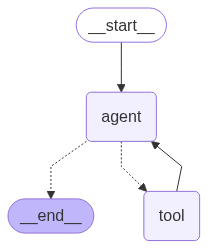

In [109]:
graph

In [110]:
def run_vqc_prediction(user_message: str):
    """Executa a predição VQC a partir de uma mensagem do usuário"""
    initial_state = {
        "messages": [HumanMessage(content=user_message)],
        "step_count": 0
    }
    
    config = {"recursion_limit": 10}
    result = graph.invoke(initial_state, config=config)
    
    # Retorna a última mensagem (resultado da ferramenta)
    for msg in reversed(result["messages"]):
        if isinstance(msg, ToolMessage):
            return msg.content
    
    return "Nenhum resultado encontrado"

In [111]:
for x in X_test:
    print(x)
    break

[tensor(1, requires_grad=False) tensor(False, requires_grad=False)
 tensor(True, requires_grad=False) tensor(False, requires_grad=False)]


In [112]:
user_input = "Faça predições com VQC para y=[1,-1], X=[[0,0,1,0],[0,0,1,0]]"
result = run_vqc_prediction(user_input)
print(result)

Executando tool call: vqc_predict com args: {'y_test_dummy': [1.0, -1.0], 'X_test': [[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0]]}

--- Executando a ferramenta de predição VQC... ---
--- Ferramenta concluiu a execução. ---

A predição com o VQC foi concluída com sucesso.
Acurácia no conjunto de teste: 50.00%
Resultados:
  - Verdadeiros Positivos (previu 1, era 1): 1
  - Verdadeiros Negativos (previu 0, era 0): 0
  - Falsos Positivos (previu 1, era 0): 1
  - Falsos Negativos (previu 0, era 1): 0

